## 1. 필요 정보 import 및 시드 고정

In [22]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

def seed_all(seed = 1930):
    
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)  # pytorch (both CPU and CUDA)
    np.random.seed(seed)  # for numpy pseudo-random generator
    #random.seed(seed)  # set fixed value for python built-in pseudo-random generator
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    
seed_all(49)

## 2. csv 정보 로드 및 데이터 변환

In [23]:
train_df = pd.read_csv('input/data/train/train.csv') #데이터셋
train_dir = list(glob('input/data/train/images/*')) #이미지들 => 폴더 내에 들어있음. => 24번째부터 폴더명 [24:]

#gender를 숫자형으로 변환 => male 1 / female 2
def gender_convert(gender) :
    if gender == 'male' : return 0
    return 3

#age를 범주형으로 변환 => 30세 미만, 30~60세, 60세 이상
def age_convert(age) :
    if age < 30 : return 0
    elif age < 58 : return 1
    return 2

train_df['gender'] = train_df['gender'].apply(lambda x : gender_convert(x))
train_df['age'] = train_df['age'].apply(lambda x : age_convert(x))

train_df.head()

,id,gender,race,age,path
0,000001,3,Asian,1,000001_female_Asian_45
1,000002,3,Asian,1,000002_female_Asian_52
2,000004,0,Asian,1,000004_male_Asian_54
3,000005,3,Asian,2,000005_female_Asian_58
4,000006,3,Asian,2,000006_female_Asian_59


## 3. 라벨 만들기

In [24]:
'''
착 0 / 제대로 6 / 안착 12
남 0 / 여 3
<30 0 / <60 1 / 2
클래스   마스크    성별   나이
0         착        남     <30  0+0+0
1         착        남     <60  0+0+1
2         착        남          0+0+2
3         착        여     <30  0+3+0
4         착        여     <60  0+3+1
5         착        여          0+3+2
6        제대로     남     <30  6+0+0
7        제대로     남     <60  6+0+1
8        제대로     남          6+0+2
9        제대로     여     <30  6+3+0
10       제대로     여     <60  6+3+1
11       제대로     여          6+3+2
12        안착      남     <30  12+0+0
13        안착      남     <60  12+0+1
14        안착      남          12+0+2
15        안착      여     <30  12+3+0
16        안착      여     <60  12+3+1
17        안착      여          12+3+2
'''

train_df['label'] = train_df['gender'] + train_df['age']
image_list = train_df['path']
label_list = train_df['label']
image_list = np.array(image_list)
label_list = np.array(label_list)

train_df.head()

,id,gender,race,age,path,label
0,000001,3,Asian,1,000001_female_Asian_45,4
1,000002,3,Asian,1,000002_female_Asian_52,4
2,000004,0,Asian,1,000004_male_Asian_54,1
3,000005,3,Asian,2,000005_female_Asian_58,5
4,000006,3,Asian,2,000006_female_Asian_59,5


## 4. 데이터 로더 생성

폴더별로 7장을 불러와, 배치 사이즈를 5로 해서 한 번에 35장 학습 (2의 배수에 가장 유사하게 맞추기 위해)

데이터셋이 많은 편이 아니라 별도의 검증 데이터를 두지는 않음.

실험 결과

1. 화질을 개선하니 정확도가 높아짐

2. Centercrop으로 배경과 옷 등을 없애니 정확도가 높아짐.

3. RGB Normalization을 하니 정확도가 높아짐

In [31]:
import cv2

#CLAHE
def clahe_cvt(own_img) :
    lab = cv2.cvtColor(own_img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    cla_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    return cla_img

#SHARPEN
def sharpen_cvt(own_img) :
    kernel_sharpen_1 = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    shp_img = cv2.filter2D(own_img, -1, kernel_sharpen_1)
    
    return shp_img
    

#데이터 로드
#데이터셋 먼저
class testdata(Dataset) :
    def __init__(self, dir_list, image_list, label_list, transform) :
        self.dir_list = dir_list
        self.image_list = image_list
        self.label_list = label_list
        self.transform = transform
        
    def __len__(self) :
        return len(self.image_list)
    
    def __getitem__(self, index) :
        img_dir = self.dir_list[index]
        dir_len = len(img_dir)+1
        img_name = img_dir[24:]
        index = np.where(self.image_list == img_name)
        label = self.label_list[index]
        
        img_list = torch.FloatTensor()
        label_list = list()
        img_dir = glob(img_dir + '/*')
        for i, img in enumerate(img_dir) :
            #원본
            own_img = cv2.imread(img)
            
            #CLAHE 버전
            cla_img = clahe_cvt(own_img)
            
            cla_img = self.transform(cla_img).reshape(1, -1, 224, 224)
            
            if img[dir_len:] in ['mask1.jpg', 'mask2.jpg', 'mask3.jpg', 'mask4.jpg', 'mask5.jpg', 'mask1.png', 'mask2.png', 'mask3.png', 'mask4.png', 'mask5.png',
                                'mask1.jpeg', 'mask2.jpeg', 'mask3.jpeg', 'mask4.jpeg', 'mask5.jpeg'] : 
                label_list.append(label)
            elif img[dir_len:] in ['normal.jpg', 'normal.png', 'normal.jpeg'] : 
                label_list.append(label + 12)
            else : 
                label_list.append(label + 6)
            
            if i == 0 :  img_list = cla_img
            else : img_list = torch.cat([img_list, cla_img], dim = 0)
        label_list = torch.LongTensor(label_list)
        
        return img_list, label_list
        
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((350,350)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))
])

train_data = testdata(train_dir, image_list, label_list, transform)
train_data = DataLoader(train_data, batch_size = 5, shuffle = True) #7*5=32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 7, 3, 224, 224]) torch.Size([5, 7, 1])
torch.Size([35, 3, 224, 224]) torch.Size([5, 7, 1])


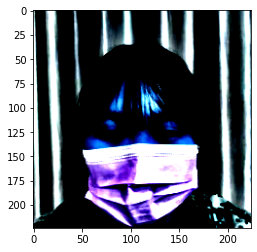

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


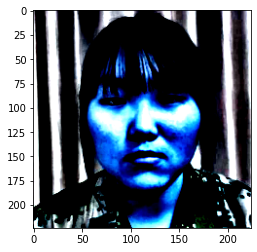

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


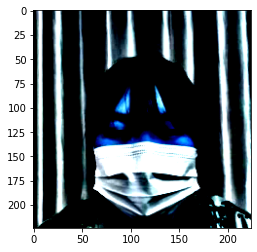

In [32]:
for x, y in train_data :
    print(x.shape, y.shape)
    x = x.reshape(-1, 3, 224, 224)
    print(x.shape, y.shape)
    plt.imshow(x[0].permute(1, 2, 0))
    plt.show()
    plt.imshow(x[1].permute(1, 2, 0))
    plt.show()
    plt.imshow(x[2].permute(1, 2, 0))
    plt.show()
    break

In [32]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## 5. 모델 구성

모델은 efficientnet 사용

실험 결과

1. resnet, densenet보다 훨씬 뛰어난 성능 보유

2. efficientnet과 resnet, densnet을 섞었을 때 단일 efficientnet보다 성능이 떨어짐

3. 모델 수가 많을 수록 성능 증가. 단, 때로는 efficientnet-b3를 빼는 것이 더 성능이 좋음

4. 이유는 모르나 pth로 저장 후 로드시 정확도가 크게 하락. 저장은 pt 로 할 것.

In [27]:
#from tqdm import tqdm
from efficientnet_pytorch import EfficientNet
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

from torch.optim import lr_scheduler
from torchvision import datasets

classes = 18
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

model_b7 = EfficientNet.from_pretrained('efficientnet-b7', num_classes = classes).to(device)
model_b6 = EfficientNet.from_pretrained('efficientnet-b6', num_classes = classes).to(device)
model_b5 = EfficientNet.from_pretrained('efficientnet-b5', num_classes = classes).to(device)
model_b4 = EfficientNet.from_pretrained('efficientnet-b4', num_classes = classes).to(device)
model_b3 = EfficientNet.from_pretrained('efficientnet-b3', num_classes = classes).to(device)

model_b7.load_state_dict(torch.load('modelb7__clahe_only.pt'))
model_b6.load_state_dict(torch.load('modelb6__clahe_only.pt'))
model_b5.load_state_dict(torch.load('modelb5__clahe_only.pt'))
model_b4.load_state_dict(torch.load('modelb4__clahe_only.pt'))
model_b3.load_state_dict(torch.load('modelb3__clahe_only.pt'))

optimizer_7 = optim.Adam(model_b7.parameters(), lr = 0.001)
criterion_7 = nn.CrossEntropyLoss()
scheduler_7 = lr_scheduler.StepLR(optimizer_7, step_size = 7, gamma = 0.1)


optimizer_6 = optim.Adam(model_b6.parameters(), lr = 0.001)
criterion_6 = nn.CrossEntropyLoss().to(device)
scheduler_6 = lr_scheduler.StepLR(optimizer_6, step_size = 7, gamma = 0.1)


optimizer_5 = optim.Adam(model_b5.parameters(), lr = 0.001)
criterion_5 = nn.CrossEntropyLoss().to(device)
scheduler_5 = lr_scheduler.StepLR(optimizer_5, step_size = 7, gamma = 0.1)


optimizer_4 = optim.Adam(model_b4.parameters(), lr = 0.001)
criterion_4 = nn.CrossEntropyLoss()
scheduler_4 = lr_scheduler.StepLR(optimizer_4, step_size = 7, gamma = 0.1)


optimizer_3 = optim.Adam(model_b3.parameters(), lr = 0.001)
criterion_3 = nn.CrossEntropyLoss().to(device)
scheduler_3 = lr_scheduler.StepLR(optimizer_3, step_size = 7, gamma = 0.1)

Loaded pretrained weights for efficientnet-b7
Loaded pretrained weights for efficientnet-b6
Loaded pretrained weights for efficientnet-b5
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b3


## 6. 학습

과적합 방지를 위해 earlystop 조건 설정.

실험 결과

1. acc 0.99 이상으로 설정시 과적합 가능성 충분

2. acc 0.95 ~ 0.98이 가장 성능이 좋음

In [39]:
from tqdm import tqdm

n_epoch = 50

model_b7.train()

for epoch in range(n_epoch) :
    epoch_7_loss = 0
    epoch_7_acc = 0
    
    for i, (x, y) in tqdm(enumerate(train_data)) :
        optimizer_7.zero_grad()
        y = y.reshape(-1).to(device)
        x = x.reshape(-1, 3, 224, 224).to(device)
        
        predict = model_b7(x)
        loss = criterion_7(predict, y)
        
        epoch_7_loss += loss.item() / x.shape[0]
        correct_prediction = torch.argmax(predict, 1) == y
        correct_prediction = correct_prediction.sum().float()
        epoch_7_acc += correct_prediction / x.shape[0]
        
        loss.backward()
        optimizer_7.step()
        
    epoch_7_loss = epoch_7_loss / (len(train_data))
    epoch_7_acc = epoch_7_acc / (len(train_data))
    print('b7 model')
    print('Epoch : {}/{},   loss : {:.5f},    acc : {:.5f}'.format(epoch+1, n_epoch, epoch_7_loss, epoch_7_acc))
    torch.save(model_b7.state_dict(), 'modelb7__aug.pt')
    if epoch_7_loss < 0.003 and epoch_7_acc > 0.97 : break
    scheduler_7.step()

562it [21:00,  2.24s/it]


b7 model
Epoch : 1/50,   loss : 0.00032,    acc : 0.99720


In [43]:
n_epoch = 50

model_b6.train()

for epoch in range(n_epoch) :
    epoch_6_loss = 0
    epoch_6_acc = 0
    
    for i, (x, y) in tqdm(enumerate(train_data)) :
        optimizer_6.zero_grad()
        y = y.reshape(-1).to(device)
        x = x.reshape(-1, 3, 224, 224).to(device)
        predict = model_b6(x)
        loss = criterion_6(predict, y)

        epoch_6_loss += loss.item() / x.shape[0]
        correct_prediction = torch.argmax(predict, 1) == y
        correct_prediction = correct_prediction.sum().float()
        epoch_6_acc += correct_prediction / x.shape[0]

        loss.backward()
        optimizer_6.step()
        
            
    epoch_6_loss = epoch_6_loss / (len(train_data))
    epoch_6_acc = epoch_6_acc / (len(train_data))
    print('b6 model')
    print('Epoch : {}/{},   loss : {:.5f},    acc : {:.5f}'.format(epoch+1, n_epoch, epoch_6_loss, epoch_6_acc))
    torch.save(model_b6.state_dict(), 'modelb6__aug.pt')
    if epoch_6_loss < 0.003 and epoch_6_acc > 0.97 : break
    scheduler_6.step()

562it [19:17,  2.06s/it]


b6 model
Epoch : 1/50,   loss : 0.00019,    acc : 0.99847


In [44]:
n_epoch = 50

model_b5.train()

for epoch in range(n_epoch) :
    epoch_5_loss = 0
    epoch_5_acc = 0
    
    for i, (x, y) in tqdm(enumerate(train_data)) :
        optimizer_5.zero_grad()
        y = y.reshape(-1).to(device)
        x = x.reshape(-1, 3, 224, 224).to(device)
        predict = model_b5(x)
        loss = criterion_5(predict, y)

        epoch_5_loss += loss.item() / x.shape[0]
        correct_prediction = torch.argmax(predict, 1) == y
        correct_prediction = correct_prediction.sum().float()
        epoch_5_acc += correct_prediction / x.shape[0]

        loss.backward()
        optimizer_5.step()
        
    epoch_5_loss = epoch_5_loss / (len(train_data))
    epoch_5_acc = epoch_5_acc / (len(train_data))
    print('b5 model')
    print('Epoch : {}/{},   loss : {:.5f},    acc : {:.5f}'.format(epoch+1, n_epoch, epoch_5_loss, epoch_5_acc))
    torch.save(model_b5.state_dict(), 'modelb5__aug.pt')
    if epoch_5_loss < 0.003 and epoch_5_acc > 0.97 : break
    scheduler_5.step()

114it [03:42,  1.95s/it]


KeyboardInterrupt: 

In [ ]:
n_epoch = 50

model_b4.train()

for epoch in range(n_epoch) :
    epoch_4_loss = 0
    epoch_4_acc = 0
    
    for i, (x, y) in tqdm(enumerate(train_data)) :
        optimizer_4.zero_grad()
        y = y.reshape(-1).to(device)
        x = x.reshape(-1, 3, 224, 224).to(device)
        predict = model_b4(x)
        loss = criterion_4(predict, y)

        epoch_4_loss += loss.item() / x.shape[0]
        correct_prediction = torch.argmax(predict, 1) == y
        correct_prediction = correct_prediction.sum().float()
        epoch_4_acc += correct_prediction / x.shape[0]

        loss.backward()
        optimizer_4.step()
        
    epoch_4_loss = epoch_4_loss / (len(train_data))
    epoch_4_acc = epoch_4_acc / (len(train_data))
    print('b4 model')
    print('Epoch : {}/{},   loss : {:.5f},    acc : {:.5f}'.format(epoch+1, n_epoch, epoch_4_loss, epoch_4_acc))
    torch.save(model_b4.state_dict(), 'modelb4__aug.pt')
    if epoch_4_loss < 0.003 and epoch_4_acc > 0.97 : break
    scheduler_4.step()

In [ ]:
n_epoch = 50

model_b3.train()

for epoch in range(n_epoch) :
    epoch_3_loss = 0
    epoch_3_acc = 0
    
    for i, (x, y) in tqdm(enumerate(train_data)) :
        optimizer_3.zero_grad()
        y = y.reshape(-1).to(device)
        x = x.reshape(-1, 3, 224, 224).to(device)
        predict = model_b3(x)
        loss = criterion_3(predict, y)

        epoch_3_loss += loss.item() / x.shape[0]
        correct_prediction = torch.argmax(predict, 1) == y
        correct_prediction = correct_prediction.sum().float()
        epoch_3_acc += correct_prediction / x.shape[0]
        
        loss.backward()
        optimizer_3.step()
        
    epoch_3_loss = epoch_3_loss / (len(train_data))
    epoch_3_acc = epoch_3_acc / (len(train_data))
    print('b3 model')
    print('Epoch : {}/{},   loss : {:.5f},    acc : {:.5f}'.format(epoch+1, n_epoch, epoch_3_loss, epoch_3_acc))
    torch.save(model_b3.state_dict(), 'modelb3__aug.pt')
    if epoch_3_loss < 0.003 and epoch_3_acc > 0.97 : break
    scheduler_3.step()

## 결과물 출력 및 저장

b7, b6, b5 모델들의 결과를 softvote 하여 저장 : till_3.csv

b7, b6, b5, b4 모델들의 결과를 softvote하여 저장 : till_4.csv

b7. b6, b5, b4, b3 모델들의 결과를 softvote하여 저장 : efficient_5models_submission.csv

In [45]:
## 결과물 출력 준비
valid_df = pd.read_csv('input/data/eval/info.csv')
img_names = valid_df['ImageID']
valid_img = list(glob('input/data/eval/images/*')) #23부터

#fivecrop을 위해 별도 선언했으나, 사실 필요 없음.
transform_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((350,350)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2)),
    #tadd_modulesforms.FiveCrop((224,224)),
])

'''
model_b7.load_state_dict(torch.load('modelb7__clahe_only.pt'))
model_b6.load_state_dict(torch.load('modelb6__clahe_only.pt'))
model_b5.load_state_dict(torch.load('modelb5__clahe_only.pt'))
model_b4.load_state_dict(torch.load('modelb4__clahe_only.pt'))
model_b3.load_state_dict(torch.load('modelb3__clahe_only.pt'))
'''

model_b3.eval()
model_b4.eval()
model_b5.eval()
model_b6.eval()
model_b7.eval()

prediction_3 = np.zeros(len(img_names))
prediction_4 = np.zeros(len(img_names))
prediction_5 = np.zeros(len(img_names))

with torch.no_grad() :
    for imgs in tqdm(valid_img) :
        img = imgs[23:]
        imgs_own = cv2.imread(imgs)
        imgs_cla = clahe_cvt(imgs_own)
        imgs_cla = transform_val(imgs_cla).reshape(1, 3, 224, 224).to(device)
        
        b3_predict_c = model_b3(imgs_cla)
        b4_predict_c = model_b4(imgs_cla)
        b5_predict_c = model_b5(imgs_cla)
        b6_predict_c = model_b6(imgs_cla)
        b7_predict_c = model_b7(imgs_cla)
        
        predict_2 = b6_predict_c + b7_predict_c
        predict_3 = b5_predict_c + b6_predict_c + b7_predict_c
        predict_4 = predict_3 + b4_predict_c
        predict_5 = predict_4 + b3_predict_c
        
        predict_2 = torch.argmax(predict_2).item()
        predict_3 = torch.argmax(predict_3).item()
        predict_4 = torch.argmax(predict_4).item()
        predict_5 = torch.argmax(predict_5).item()
        
        idx = np.where(img_names == img)
        prediction_2[idx] = int(predict_2)
        prediction_3[idx] = int(predict_3)
        prediction_4[idx] = int(predict_4)
        prediction_5[idx] = int(predict_5)

valid_df['ans'] = prediction_2
valid_df.to_csv('2.csv', index = False)
valid_df['ans'] = prediction_3
valid_df.to_csv('3.csv', index = False)
valid_df['ans'] = prediction_4
valid_df.to_csv('4.csv', index = False)
valid_df['ans'] = prediction_5
valid_df.to_csv('5.csv', index = False)

100%|██████████| 12600/12600 [49:19<00:00,  4.26it/s]


"\nvalid_df['ans'] = whole_prediction_own\nvalid_df.to_csv('own_only.csv', index = False)\n#valid_df['ans'] = whole_prediction_shp\n#valid_df.to_csv('shp_only.csv', index = False)\nvalid_df['ans'] = whole_prediction_cla\nvalid_df.to_csv('cla_only.csv', index = False)\n#valid_df['ans'] = whole_prediction_shp_cla\n#valid_df.to_csv('shp_cla.csv', index = False)\n#valid_df['ans'] = whole_prediction_shp_own\n#valid_df.to_csv('shp+own.csv', index = False)\nvalid_df['ans'] = whole_prediction_cla_own\nvalid_df.to_csv('cla+own.csv', index = False)\n#valid_df['ans'] = whole_prediction_aug\n#valid_df.to_csv('all_pre.csv', index = False)\n"

In [14]:
#기타 명령어
#사용 가능 용량 확인
!df -h

#휴지통 비우기
#!rm -r ./.local/share/Trash/files 

Filesystem      Size  Used Avail Use% Mounted on
overlay          48G   31G   15G  68% /
tmpfs            64M     0   64M   0% /dev
tmpfs            89G     0   89G   0% /sys/fs/cgroup
shm             1.0G  4.0K  1.0G   1% /dev/shm
/dev/xvda1       48G   31G   15G  68% /etc/hosts
tmpfs            89G   12K   89G   1% /proc/driver/nvidia
udev             89G     0   89G   0% /dev/nvidia1
tmpfs            89G     0   89G   0% /proc/acpi
tmpfs            89G     0   89G   0% /proc/scsi
tmpfs            89G     0   89G   0% /sys/firmware


In [21]:
#데이터 증강 시도 : 토론의 김상훈 캠퍼님 코드

import numpy as np
from PIL import Image, ImageEnhance, ImageOps
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# torch
import torch
import torchvision.transforms as transforms

# 경로 설정 하기
train_dir = 'input/data/train' # 환경마다 다름
train_csv_dir = os.path.join(train_dir, 'train.csv')
df = pd.read_csv(train_csv_dir)

# 둘 중에 선택
transform_c = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                transforms.RandomRotation(20), # 20도 회전
                                #transforms.GaussianBlur((5,5), sigma=(0.5, 2.0)), # 커널 크기 (5,5) 로 blur 처리. 쿠다 버젼에 따라 안될 수 있음.
                                transforms.ColorJitter(brightness=(0.8, 1.5), contrast=0.5, saturation=0.5),## 밝기, 대비, 채도 
                               ])

BASE_DIR = train_dir + '/images'

last_id = int(df.iloc[-1][0]) + 1
len_df = 2700 # len(df) # 2700 으로 고정한 이유: transform 이 중복되면서 이미지 품질이 떨어지기 때문에 원본의 양인 2700으로 설정.

for idx in tqdm(range(len_df)):
    line = df.iloc[idx]
    path = os.path.join(BASE_DIR, line[-1])
    file_name = os.listdir(path)
    new_idx, gender, _, age = path.split('_')
    
    string_id = str(last_id).rjust(6,'0') # 00xxxx 로 만들어줌
    save_folder = string_id +'_'+ gender + '_Asian_' + age # 새로 만들 폴더 제목 (수정 필요 없음)
    if int(age) >=60 and gender == 'female': # 증강시키고 싶은 데이터의 조건을 설정하세요. 
        os.mkdir(os.path.join(BASE_DIR,save_folder))
        for file in file_name:
            if file[0] == '.':
                continue
            tmp = list(line[:])
            tmp[-1] = os.path.join(line[-1], file)
            img_path = os.path.join(BASE_DIR, tmp[-1])
            image = Image.open(img_path)
            
            # save 
            save_path = os.path.join(BASE_DIR,save_folder,file)
            image = transform_c(image)
            image.save(save_path)
        
        # 데이터 프레임에 마지막 행 추가
        new_data = [last_id, gender, 'Asian', age, save_folder]
        df.loc[last_id] = new_data
        last_id += 1
        #break # 테스트용. 먼저 1개만 만들어서 테스트 해보기를 권장. => 확인 후 생성 된 폴더 삭제해도 됩니다.


# csv 파일에 저장하기
df.to_csv(train_csv_dir, index = False)

100%|██████████| 2700/2700 [00:14<00:00, 189.23it/s]
